<a href="https://colab.research.google.com/github/wilberquito/Thesis/blob/main/Code/pytorch/notebooks/resnet18/ResNet18_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet18, V1

In [1]:
!pip install wandb >/dev/null 2>&1

In [2]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0


In [3]:
import requests
from pathlib import Path
import pandas as pd
import seaborn as sns
from zipfile import ZipFile

try:
    import google.colab
    from google.colab import drive
    IN_COLAB = True
    drive.mount('/content/drive')
except:
    IN_COLAB = False

print(f"In colab: {IN_COLAB}")

In colab: False


In [4]:
def pull_code():
  print("Unzipping the code from google drive")
  !rm -rf modular/
  !unzip ./drive/MyDrive/wilberquito_thesis/modular.zip -d . >/dev/null 2>&1

if IN_COLAB:
    pull_code()

In [5]:
def pull_data():
  answer = input("You sure? Y/n\n")
  if answer != "Y":
    return

  print("Unzipping the data from google drive")
  !rm -rf data.etl/
  !unzip ./drive/MyDrive/wilberquito_thesis/data.zip -d . >/dev/null 2>&1

if IN_COLAB:
    pull_data()

In [6]:
!nvidia-smi

Thu Jun 22 08:24:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:31:00.0 Off |                   On |
| N/A   44C    P0    47W / 300W |      0MiB / 81920MiB |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:4B:00.0 Off |                   On |
| N/A   

## Scheduler

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 20
STEP_SIZE = 15
GAMMA = 0.2

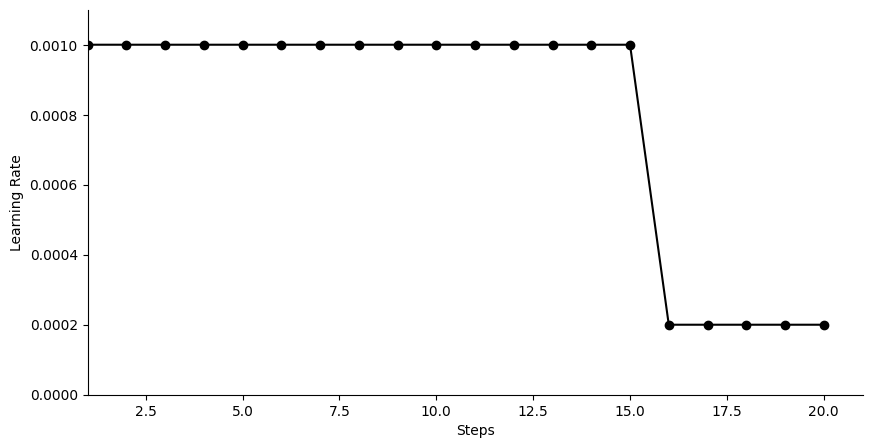

In [8]:
import torch
import torch.optim.lr_scheduler as lr_scheduler # Import your choice of scheduler here
import modular.utility as m_utility

# Set model and optimizer
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Define your scheduler here as described above
scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

m_utility.plot_learning_rate_scheduler(optimizer,
                                       scheduler,
                                       LEARNING_RATE,
                                       EPOCHS)

## Batch Size

In [9]:
BATCH_SIZE=400

## WANB

In [10]:
import wandb

key = "c1121fe51146c1da87d1139239da7748c4e78665"
wandb.login(key=key)

wandb: Currently logged in as: wilberquto (wilberquito). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/student2/.netrc


True

In [11]:
wandb.finish()

In [12]:
wandb.init(
    # set the wandb project where this run will be logged
    project="melanoma_thesis",
    group="train_test",
    name= "ResNet18_V1",
    config={
      "architecture": "ResNet18",
      "scheduler": "StepLR",
      "dataset": "ISIC",
      "learning_rate": LEARNING_RATE,
      "batch_size": BATCH_SIZE,
      "epochs": EPOCHS,
      "step_size": STEP_SIZE,
      "gamma": GAMMA
    }
)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.4
wandb: Run data is saved locally in /home/student2/thesis/pytorch/wandb/run-20230622_082511-2npoo4gg
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ResNet18_V1
wandb: ⭐️ View project at https://wandb.ai/wilberquito/melanoma_thesis
wandb: 🚀 View run at https://wandb.ai/wilberquito/melanoma_thesis/runs/2npoo4gg


## Writter

In [13]:
import modular.utility as m_utility

writter = m_utility.model_writter('resnet18_v1')

## Train

In [14]:
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.models import (ResNet18_Weights)
from torch.utils.data import DataLoader
import torch
import torchvision as tv
import modular.dataset as m_dataset
import modular.utility as m_utility
import modular.engine as engine
import modular.models as m_models

# Set seed
m_utility.set_seed(42)

# Build the dataframes
data_dir = 'data.etl'
data_folder = '512'
train_df, _, mapping = m_dataset.get_df(data_dir, data_folder)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

out_features = len(mapping)
model = m_models.ResNet18_Melanoma(out_features)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)


# Mapping from id to classname
idx_to_class = { k : classname for classname, k in mapping.items() }

# Train and validate dataset & dataloader
train_df, validate_df = m_dataset.train_validate_split(train_df,
                                                       random_state=42,
                                                       validate_size=0.2)

validate_df, test_df = m_dataset.train_validate_split(validate_df,
                                                      random_state=42,
                                                      validate_size=0.5)


train_transforms, val_transforms = m_dataset.get_transforms(image_size=256)
train_transforms = val_transforms

train_dataset = m_dataset.MelanomaDataset(train_df,
                                          mode='train',
                                          transforms=train_transforms,
                                          idx_to_class=idx_to_class)
validate_dataset = m_dataset.MelanomaDataset(validate_df,
                                             mode='validate',
                                             transforms=val_transforms,
                                             idx_to_class=idx_to_class)

batch_size = BATCH_SIZE

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_dataloader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)

# Dataloaders
dataloaders = {
    'train': train_dataloader,
    'val': validate_dataloader,
}

datasets_size = {
    'train': len(train_dataset),
    'val': len(validate_dataset),
}

about_data = {
    'dataloaders': dataloaders,
    'datasets': {
        'size': datasets_size
    }
}

MEL_IDX = 6 # Check data exploration notebook
VAL_TIMES = 4

model_ft, stats = engine.train_model(model,
                                     MEL_IDX,
                                     about_data,
                                     device,
                                     criterion,
                                     optimizer,
                                     scheduler,
                                     num_epochs=EPOCHS,
                                     writter=writter,
                                     val_times=VAL_TIMES)

/home/student2/.conda/envs/melanoma_nn/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


Epoch 1/20
----------
Train OvR: 0.7096 	|	Train Loss: 1.1262 	|	Train Acc: 0.6268
Val OvR: 0.8131 	|	Val Loss: 0.9215 	|	Val Acc: 0.6740
=> Saving a new checkpoint
Epoch 2/20
----------
Train OvR: 0.8386 	|	Train Loss: 0.8617 	|	Train Acc: 0.6985
Val OvR: 0.8420 	|	Val Loss: 0.8413 	|	Val Acc: 0.6983
=> Saving a new checkpoint
Epoch 3/20
----------
Train OvR: 0.8613 	|	Train Loss: 0.7915 	|	Train Acc: 0.7190
Val OvR: 0.8541 	|	Val Loss: 0.8018 	|	Val Acc: 0.7092
=> Saving a new checkpoint
Epoch 4/20
----------
Train OvR: 0.8763 	|	Train Loss: 0.7428 	|	Train Acc: 0.7369
Val OvR: 0.8628 	|	Val Loss: 0.7679 	|	Val Acc: 0.7210
=> Saving a new checkpoint
Epoch 5/20
----------
Train OvR: 0.8891 	|	Train Loss: 0.7001 	|	Train Acc: 0.7504
Val OvR: 0.8688 	|	Val Loss: 0.7438 	|	Val Acc: 0.7297
=> Saving a new checkpoint
Epoch 6/20
----------
Train OvR: 0.8995 	|	Train Loss: 0.6634 	|	Train Acc: 0.7636
Val OvR: 0.8745 	|	Val Loss: 0.7238 	|	Val Acc: 0.7351
=> Saving a new checkpoint
Epoch 7/20

In [15]:
wandb.finish()

wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:  train_acc ▁▃▃▄▄▄▅▅▅▆▆▆▇▇▇█████
wandb: train_loss █▆▅▅▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁
wandb:  train_ovr ▁▄▅▅▆▆▆▆▇▇▇▇▇███████
wandb:    val_acc ▁▃▃▄▅▅▆▆▆▇▇▇▇███████
wandb:   val_loss █▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
wandb:    val_ovr ▁▃▄▅▅▆▆▇▇▇▇▇████████
wandb: 
wandb: Run summary:
wandb:  train_acc 0.9005
wandb: train_loss 0.3221
wandb:  train_ovr 0.98
wandb:    val_acc 0.7796
wandb:   val_loss 0.6325
wandb:    val_ovr 0.9003
wandb: 
wandb: 🚀 View run ResNet18_V1 at: https://wandb.ai/wilberquito/melanoma_thesis/runs/2npoo4gg
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230622_082511-2npoo4gg/logs


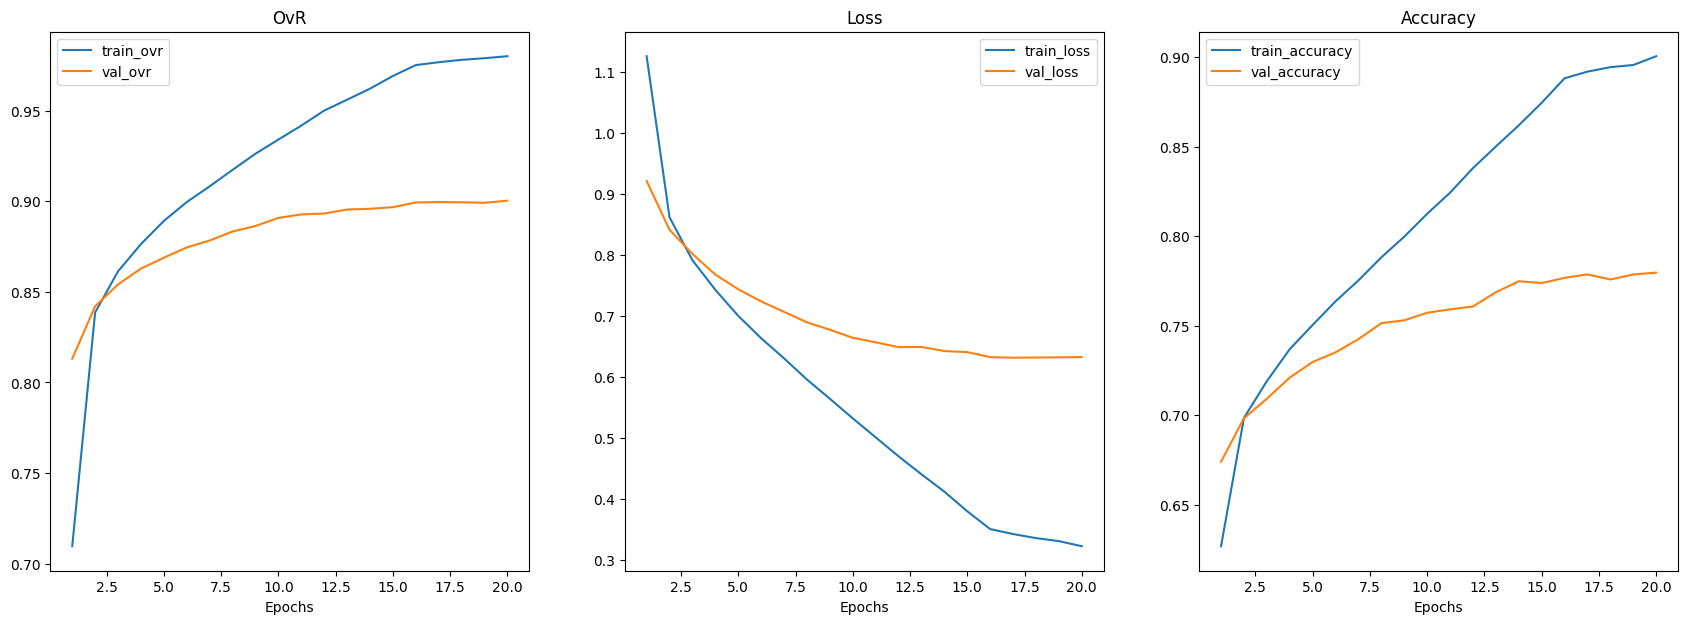

In [16]:
m_utility.plot_curves(stats)

In [17]:
if IN_COLAB:
  from google.colab import files
  files.download('resnet18_v1.pth.tar')
  files.download('resnet18_v1.csv')